# Лабораторная работа № 5
### Минимальная оценка - 3 балла
### Максимальная оценка - 5 балла
Целью данной работы является изучение метода построения нейронной сети для многоклассовой классификации.
Для успешной сдачи лабораторной работы Вам необходимо предоставить заполненый исходный ноутбук.

In [1]:
import copy
import math

import numpy as np
from matplotlib import pyplot as plt
import tqdm
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

# Метод обратного распространения ошибок

Метод обратного распространения ошибок - метод вычисления градиента, используемый при обновлении весов 
многослойного перцептрона. Основная идея этого метода состоит в распространении сигналов ошибки от выходов 
сети к её входам, в направлении, обратном прямому распространению сигналов в обычном режиме работы.

Метод является модификацией стохастического градиентного спуска и состоит из нескольких ступеней. 

# 1.1 Стохастический градиентный спуск

Обновление весов с учетом leraning rate и градиента можно проводить по следующей формуле:
$$ \mathit{weights} =  \mathit{weights}-\mathit{learning\_rate} * \mathit{gradient}  $$

Реализуйте класс для стохастического градиента.

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.learning_rate = lr 

    def update(self, w, w_grad):
        return w - self.learning_rate * w_grad

# 1.2 Функции активации

Функция активации определяет выходное значение нейрона в зависимости от результата взвешенной суммы входов
и порогового значения. 

Рассмотрим нейрон:

$$ \mathit{Y} = \sum(\mathit{weight}*\mathit{input}) + \mathit{bias}$$

Теперь значение Y может быть любым в диапазоне от минус бесконечности до бесконечности. В действительности нейрон не знает границу, после которой следует активация.Необходимо решить вопрос как должен нейрон быть активирован. Для этих целей используют активационные функции. Она проверяет произведенное нейроном значение Y на предмет того, должны ли внешние связи рассматривать этот нейрон как активированный, или его можно игнорировать.

Вопрос: какими свойствами должна обладать функция активации? (непрерывностью, дифференцируемостью и являться монотонно неубывающей)
Вопрос 2: какими свойствами должна обладать производная функции активации? (для простоты вычислений нужно, чтобы производная легко находилась)

В данной работе используюется хорошо знакомая по предыдущим работам фанкция активации в виде сигмоиды:
$$ \sigma (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{- \theta^Tx} }  $$

Производная сигмоиды имеет следующий вид:
$$\sigma (z)' = \sigma (z) (1 - \sigma (z))$$

Реализуйте класс, вызывающий сигмоиду при прямом прохождении по слоям нейросети и её производную при обратном распространении ошибок.

Риторический вопрос 1: что из выше указанного используется при прямом распространении сигналов, а что при обратном распространении ошибок?


In [3]:
class Sigmoid():
    @staticmethod
    def evaluate(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def gradient(x):
        s = Sigmoid.evaluate(x)
        return s * (1 - s)

# 1.3 Функция активации Softmax 

Softmax — это обобщение логистической функции для многомерного случая. Она применяется в машинном обучении для задач классификации, когда количество возможных классов больше двух (для двух классов используется логистическая функция). Координаты полученного вектора при этом трактуются как вероятности того, что объект принадлежит к классу i:

$$ softmax(x)_i = \frac{exp(x_i)}{\sum_{j}^{ }exp(x_j))}  $$

Производная имеет следующий вид:

$$ softmax(x)' = softmax(x) (1 - softmax(x))$$

Риторический вопрос 2: что используется при прямом распространении сигнала, а что при обратном распространении ошибок?

Реализуйте свой класс Softmax и ее производной.

In [4]:
class Softmax():
    @staticmethod
    def evaluate(x):
        exp = np.exp(x - np.max(x))
        return exp / np.sum(exp, axis=-1, keepdims=True)

    @staticmethod
    def gradient(x):
        frwd = Softmax.evaluate(x)
        return frwd * (1 - frwd)

# 1.4 Предварительные шаги

Для реализации нейронной сети необходимо задать общую функциональность слоев и определить класс для активации.

1. В классе Layer реализуем метод, который задает размерность, которую слой ожидает на входе при прямом методе.
2. В классе Activation реализуем функционал применения слоем операции активации на входе. Параметр name% string - имя функции активации, которая будет использоваться.

Вам необходимо реализовать метод прямого и обратного прохождения в классе Activation.


In [5]:
class Layer():
    def set_input_shape(self, shape):
        self.input_shape = shape


class Activation(Layer):

    def __init__(self, name):
        self.activation_name = name
        
        #
        # Тут немного пошаманить пришлось, чтобы соответствовать интерфейсу активаций
        #
        
        self.activation_func = activation_functions[name]
        self.trainable = True

    def forward_pass(self, X, training=True):
        self.layer_input = X
        return self.activation_func.evaluate(X)

    def backward_pass(self, accum_grad):
        return accum_grad * self.activation_func.gradient(self.layer_input)

    def output_shape(self):
        return self.input_shape

activation_functions = {
    'sigmoid': Sigmoid,
    'softmax': Softmax
}

Теперь надо реализовать класс для реализации линейных преобразований внутри слоя нейронной сети.
Для этого используем линейную регрессию. Реализуйте градиентный спуск для нее.
Модель линейной регрессии задаётся формулой: $$\vec{y}=X\vec{w}+\mathbb{C}$$

In [6]:
class Dense(Layer):
#     Полностью подключенный слой нейронной сети.
#     Параметры:
#     -----------
#     n_units: int
#      Число нейронов в слое.
#     input_shape: tuple
#      Ожидаемая размерность входа на слой. Для плотных слоев одна цифра характеризует число 
#      признаков на входе. 
#      Должен быть задан, если слой является первый в нейронной сети

    def __init__(self, n_units, input_shape=None):
        self.layer_input = None
        self.input_shape = input_shape
        self.n_units = n_units
        self.trainable = True
        
        # Weights and optimizers (cannot set them for now)
        self.W = None
        self.W_optimizer = None
        
        self.w0 = None
        self.w0_optimizer = None

    def initialize(self, optimizer):
        #
        # Инициализация весов
        #
        
        limit = 1 / math.sqrt(self.input_shape[0])
        self.W  = np.random.uniform(-limit, limit, (self.input_shape[0], self.n_units))
        self.w0 = np.zeros((1, self.n_units))
        
        #
        # А теперь сами оптимизаторы
        #
        
        self.W_optimizer  = copy.copy(optimizer)
        self.w0_optimizer = copy.copy(optimizer)

    def forward_pass(self, X, training=True):
        self.layer_input = X
        return X.dot(self.W) + self.w0

    def backward_pass(self, accum_grad):
        #
        # Веса нам еще понадобятся
        #
        
        W = self.W

        if self.trainable:
            W_grad  = self.layer_input.T.dot(accum_grad)
            w0_grad = np.sum(accum_grad, axis=0, keepdims=True)
            self.W  = self.W_optimizer.update(self.W, W_grad)
            self.w0 = self.w0_optimizer.update(self.w0, w0_grad)

        # 
        # Отдам обратно значение градиента 
        #
        
        return accum_grad.dot(W.T)

    def output_shape(self):
        return (self.n_units, )

## Задание
Объясните код в следующей ячейке. Зачем используется batch?

In [7]:
def batch_iterator(X, y=None, batch_size=64):
    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i + batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

Честно говоря, неясно, что тут требуется объяснять... Функция-генератор принимает на вход данные и отдает их кусочками -- батчами по несколько записей (по умолчанию 64).

Батчи существенно ускоряют обучение сети, так как уменьшают количество вычислений градиента методом обратного распространения ошибки.

# 1.5 Построение нейронной сети

Реализуйте класс  NeuralNetwork ().

Параметры:

1. optimizer: class - оптимизатор весов, который будет использоваться для модификации весов, чтобы минимизировать ошибку.

2. loss: class - функция потерь, используемая для измерения производительности модели. Используйте функцию `Cross-Entropy`:
$$L = (y,p) = -y \log{p} - (1-y)\log{(1-p)}$$

Ее производная по `p`:
$$\frac{\partial L}{\partial p} = \frac{(p - y)}{p(1-p)}$$
       
3. validation: tuple - кортеж, содержащий валидирующие данные и метки (X, y)



## Реализация CrossEntropy для использования далее 
объясните код

In [8]:
class CrossEntropy():
    def __init__(self): pass

    def loss(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return - y * np.log(p) - (1 - y) * np.log(1 - p)

    def acc(self, y, p):
        return accuracy_score(np.argmax(y, axis=1), np.argmax(p, axis=1))

    def gradient(self, y, p):
        p = np.clip(p, 1e-15, 1 - 1e-15)
        return (p - y) / (p * (1 - p))

Тут еще более неясно, что надо объяснить. Есть такая замечательная функция как бинарная кросс-энтропия. Класс представляет ее реализацию.

Надо отметить, что она не переваривает 0 и 1 в качестве аргументов (логарифмы плохо дружат с нулем в качестве аргумента), поэтому в коде происходит "обрезание" переданного аргумента до значений в пределах $[\epsilon, 1 - \epsilon]$, где $\epsilon = 10 ^ {-15}$. Остальное в принципе достаточно очевидный код, написанный аккурат по описанию выше...

## Задание:
1. Реализовать метод, который замораживает веса на слое сети (def self_trainable(self, trainable))
2. Реализовать метод, добавляющий слой к нейронной сети (def add(self, layer))
3. Реализовать метод для оценки модели на одном batch образцов (def test_on_batch(self, X, y))
4. Реализовать метод для обучения на одном batch образцов (def train_on_batch(self, X, y))
5. Реализовать метод обучения модели на фиксированном количестве итераций (def fit(self, X, y, n_epochs, batch_size)) и вывод шкалы, характеризующей прогресс обучения
6. Реализовать метод прямого прохождения для расчета выхода нейронной сети (def _forward_pass(self, X, training=True))
7. Реализуйте метод обратного прохождения градиента и обновления весов на каждом из слоев (def _backward_pass(self, loss_grad))
8. Реализуйте метод классификации метки X (def predict(self, X))

In [9]:
class NeuralNetwork():
    # не менять код
    def __init__(self, optimizer, loss, validation_data=None):
        self.optimizer = optimizer
        self.layers = []
        self.errors = {'training': [], 'validation': []}
        self.loss_function = loss()
        
        # Буду tqdm использовать вместо этого
        #self.progressbar = progressbar.ProgressBar()

        self.val_set = None
        if validation_data:
            X, y = validation_data
            self.val_set = {"X": X, "y": y}

    def set_trainable(self, trainable):
        for layer in self.layers:
            layer.trainable = trainable

    def add(self, layer):
        # 
        # Если это не первый слой добавленный слой, надо установить размерность на входе
        # размерности на выходе последнего добавленного слоя
        #
        
        if len(self.layers) > 0:
            layer.set_input_shape(shape=self.layers[-1].output_shape())
        
        if hasattr(layer, 'initialize'):
            #
            # Слои активации не нужно инициализировать, хотя можно было бы 
            # просто пустую инциализацию в них сделать
            #
            
            layer.initialize(optimizer=self.optimizer)
            
        self.layers.append(layer)

    def fit(self, X, y, n_epochs, batch_size):
        for i in tqdm.tqdm(range(n_epochs)):
            #
            # Тут в целом то все предельно просто -- учимся батчами и сохраняем ошибки в историю
            #
            
            errors = []
            
            for X_batch, y_batch in batch_iterator(X, y, batch_size=batch_size):
                loss, _ = self._train_on_batch(X_batch, y_batch)
                errors.append(loss)
                
            self.errors['training'].append(np.mean(errors))
            
            if self.val_set is not None:
                val_loss, _ = self._test_on_batch(self.val_set['X'], self.val_set['y'])
                self.errors['validation'].append(val_loss)
                
        return self.errors


    def _forward_pass(self, X, training=True):
        output = X
        
        for layer in self.layers:
            output = layer.forward_pass(output, training)
            
        return output

    def _backward_pass(self, loss_grad):
        for layer in self.layers[::-1]:
            loss_grad = layer.backward_pass(loss_grad)

    def _test_on_batch(self, X, y):
        y_predicted = self._forward_pass(X, training=False)
        accuracy = self.loss_function.acc(y, y_predicted)
        
        loss = np.mean(self.loss_function.loss(y, y_predicted))
        
        return loss, accuracy

    def _train_on_batch(self, X, y):
        y_predicted = self._forward_pass(X)
        accuracy = self.loss_function.acc(y, y_predicted)
        
        loss = np.mean(self.loss_function.loss(y, y_predicted))
        loss_grad = self.loss_function.gradient(y, y_predicted)
        
        self._backward_pass(loss_grad=loss_grad)
        
        return loss, accuracy

    def predict(self, X):
        return self._forward_pass(X, training=False)

# 1.6 Проверка реализации нейронной сети

Для проверки работы нейронной сети сгенерируем датасет.

Объясните работу кода в следующей ячейке. Что будет содержать датасет?

<Figure size 640x480 with 0 Axes>

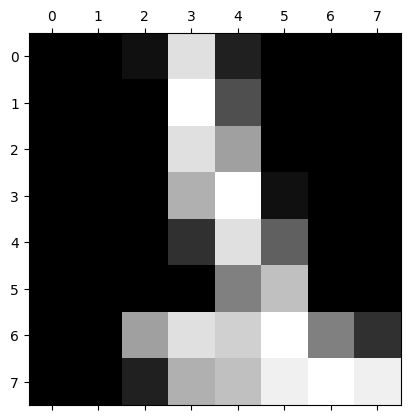

Class: 1


In [10]:
# Генерируем датасет
data = datasets.load_digits()

plt.gray()
sample_n = 1000
plt.matshow(data.images[sample_n]) 
plt.show()
print("Class:", data.target[sample_n])

## Задание
1. Подготовьте входные данные
2. Преобразуйте номер класса в бинарное представление 
3. Нормализуйте данные для признаков 
4. Разбейте датасет на обучающую и тестовую выборки.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder, 
                                   StandardScaler,)

In [12]:
data = datasets.load_digits()
X = data.data
y = data.target

In [13]:
X_transformer = Pipeline([
    ('z-score', StandardScaler())
])

y_transformer = Pipeline([
    ('one-hot', OneHotEncoder())
])

In [14]:
X = X_transformer.fit_transform(X)

In [15]:
y = y_transformer \
    .fit_transform(y.reshape(-1, 1)) \
    .toarray()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 1.7 Работа с данными

## Задание

1. Обучите вашу нейронную сеть на данных 
2. Вывести графики функций ошибок при обучении и валидации

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [18]:
network = NeuralNetwork(optimizer=SGD(lr=0.01), loss=CrossEntropy, validation_data=(X_val, y_val))

network.add(Dense(64, input_shape=(X.shape[1],)))
network.add(Activation('sigmoid'))

network.add(Dense(y.shape[1]))
network.add(Activation('softmax'))

history = network.fit(X_train, y_train, n_epochs=120, batch_size=128)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 105.80it/s]


In [19]:
train_error = history['training']
val_error = history['validation']

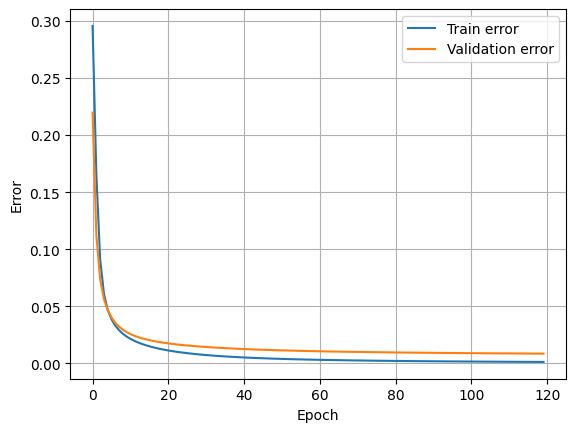

In [20]:
plt.plot(train_error, label="Train error")
plt.plot(val_error, label="Validation error")

plt.ylabel('Error')
plt.xlabel('Epoch')

plt.legend()
plt.grid()